In [1]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

In [2]:
bs = 16
size = 256

In [3]:
path = Path('/home/jupyter/HumpbackWhaleIdentification/data')
path.ls()

[PosixPath('/home/jupyter/HumpbackWhaleIdentification/data/validation'),
 PosixPath('/home/jupyter/HumpbackWhaleIdentification/data/train.csv'),
 PosixPath('/home/jupyter/HumpbackWhaleIdentification/data/test'),
 PosixPath('/home/jupyter/HumpbackWhaleIdentification/data/train'),
 PosixPath('/home/jupyter/HumpbackWhaleIdentification/data/sample_submission.csv'),
 PosixPath('/home/jupyter/HumpbackWhaleIdentification/data/models')]

## Competition evaluation metric

In [4]:
# Competition evaluation metric
def map5eval(preds, dtrain, k=5):
    actual = dtrain.get_label()
    predicted = (-preds).argsort(axis=1)[:,:k]
    metric = 0.
    for i in range(5):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@5', metric

In [5]:
# Fastai metric implementation
class map5(Callback):
    def __init__(self, func):
        self.func, self.name = func, func.__name__

    def on_epoch_begin(self, **kwargs):
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, train, **kwargs):
        self.count += last_target.size(0)
        self.val += last_target.size(0) * self.func(last_output, last_target).detach().item()

    def on_epoch_end(self, **kwargs):
        self.metric = self.val/self.count

## Data pipeline

In [6]:
train_df = pd.read_csv(path/"train.csv")
print(train_df.shape)
train_df.head()

(25361, 2)


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [7]:
labels_count = train_df.Id.value_counts()
labels_count.head()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

In [8]:
train_df.Id.nunique()

5005

In [9]:
train_names = train_df.index.values

In [10]:
tfms = get_transforms(do_flip=True)
data = ImageDataBunch.from_folder(path, train='train', valid='validation', test='test', ds_tfms=tfms, size=size, bs=bs).normalize(imagenet_stats)

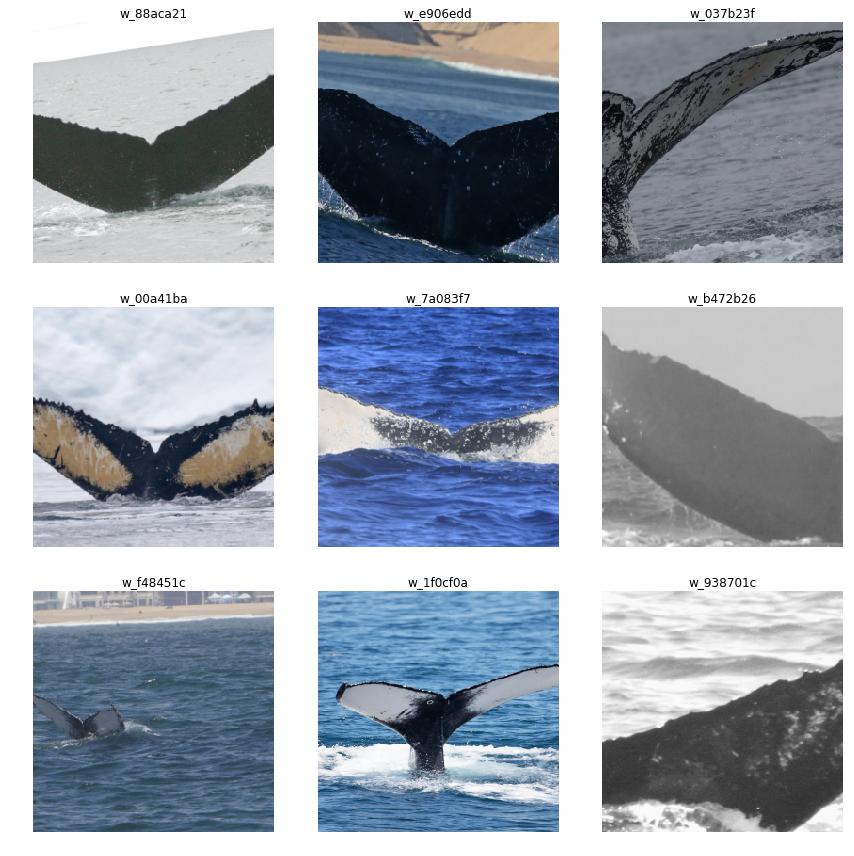

In [11]:
data.show_batch(rows=3, figsize=(12,12))

In [12]:
len(data.classes),data.c

(5005, 5005)

In [13]:
learn = create_cnn(data, models.resnet34, metrics=[error_rate, accuracy])

In [14]:
learn.fit_one_cycle(4)
learn.save('stage-2')

epoch,train_loss,valid_loss,error_rate,accuracy
1,8.593385,7.567266,0.969432,0.030568
2,7.665302,7.304246,0.975232,0.024768
3,6.871469,7.125092,0.963263,0.036737
4,6.191144,7.114933,0.958475,0.041525


In [15]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (14500 items)
x: ImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
w_2e9ed59,w_12e7c23,w_12e7c23,w_12e7c23,w_5c2bc89
Path: /home/jupyter/HumpbackWhaleIdentification/data;

Valid: LabelList (10861 items)
x: ImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
w_67a9841,w_67a9841,w_67a9841,w_93fddcb,w_dd88965
Path: /home/jupyter/HumpbackWhaleIdentification/data;

Test: LabelList (7960 items)
x: ImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /home/jupyter/HumpbackWhaleIdentification/data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

# Interpretation

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

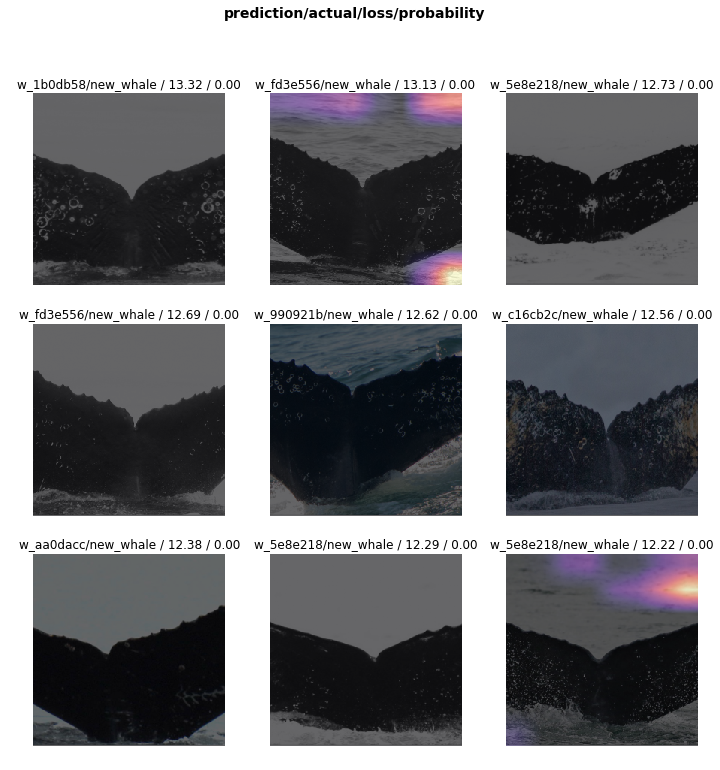

In [17]:
interp.plot_top_losses(9, figsize=(12,12))

# Unfreezing, fine-tuning, and learning rates

In [18]:
#learn.lr_find()

In [19]:
#learn.recorder.plot()

In [20]:
#learn.unfreeze()
#learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

## Make submission

In [21]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [22]:
preds.shape

torch.Size([7960, 5005])

In [23]:
def top_5_pred_labels(preds, classes):
    top_5 = np.argsort(preds.numpy())[:, ::-1][:, :5]
    labels = []
    for item in top_5:
        labels.append(' '.join([classes[whale_id] for whale_id in item]))
    return labels

def create_submission(preds, data, name, classes=None):
    if not classes: classes = data.classes
    sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
    sub['Id'] = top_5_pred_labels(preds, classes)
    sub.to_csv(f'{name}.csv', index=False)

In [24]:
create_submission(preds, data, "submission")